# About Dataset

It contains images of jaguar and a table with their labels, the images are cropped to only leave the masks and part of jaguars

# Exploration & Data loading

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import os
import io
import tqdm


In [2]:
# labels
label_table = pd.read_csv('../data/raw/train.csv')
label_table.head()

,filename,ground_truth
0,train_0001.png,Abril
1,train_0002.png,Abril
2,train_0003.png,Abril
3,train_0004.png,Akaloi
4,train_0005.png,Akaloi


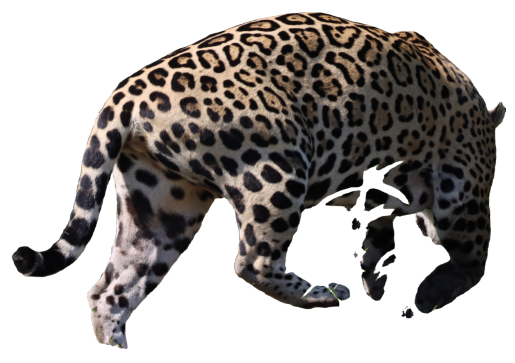

Label: Marcela


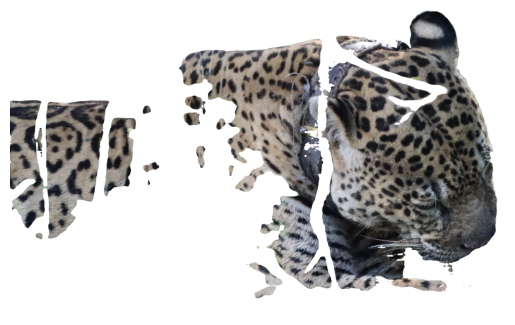

Label: Ousado


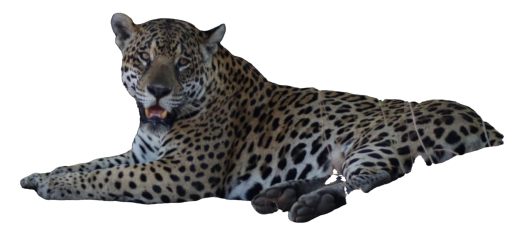

Label: Jaju


In [3]:
train_image_path = '../data/raw/train/train'

def show_image(image_path):
    '''
    Show an image given its file path.
    Args:
        image_path (str): The file path of the image to be displayed.
    '''
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def show_random_images(label_table, num_images=5):
    '''
    Show random images from the training dataset and its label.
    Args:
        label_table (pd.DataFrame): The DataFrame containing image labels and paths.
        num_images (int): The number of random images to display.    
    '''
    random_indices = np.random.choice(label_table.index, size=num_images, replace=False)
    for idx in random_indices:
        image_id = label_table.loc[idx, 'filename']
        image_path = os.path.join(train_image_path, image_id)
        show_image(image_path)
        print("Label:", label_table.loc[idx, 'ground_truth'])

show_random_images(label_table, num_images=3)

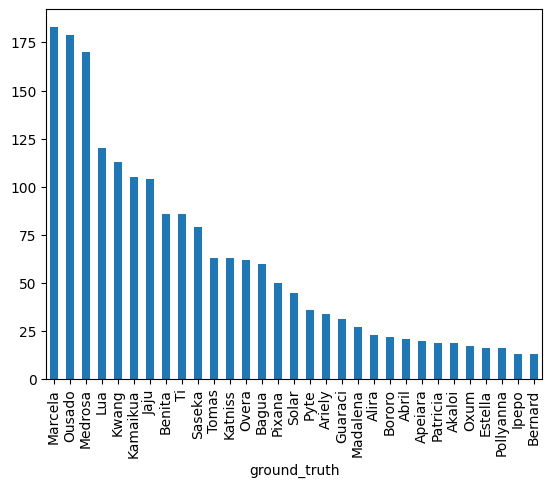

In [4]:
label_table['ground_truth'].value_counts().plot(kind='bar');

In [ ]:
def is_corrupted_pil(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify it's a valid image
            img = Image.open(image_path)  # Reopen for processing
            img.load()  # Load all pixel data
            # Check if image is mostly black
            histogram = img.convert('L').histogram()
            if sum(histogram[:50]) > sum(histogram) * 0.8:
                return "Likely too dark"
        return "OK"
    except Exception as e:
        return f"Corrupted: {str(e)}"

if not os.path.exists('intermediate'):
    os.makedirs('intermediate')

if not os.path.exists('intermediate/corruption_results.csv'):
    corruption_results = []
    for idx, row in tqdm.tqdm(label_table.iterrows(), total=label_table.shape[0]):
        image_id = row['filename']
        image_path = os.path.join(train_image_path, image_id)
        result = is_corrupted_pil(image_path)
        corruption_results.append((image_id, result))

In [ ]:
if not os.path.exists('intermediate/corruption_results.csv'):
    corruption_results_df = pd.DataFrame(corruption_results, columns=['filename', 'corruption_status'])
    corruption_results_df.to_csv('intermediate/corruption_results.csv', index=False)
    print(corruption_results_df.head())

if os.path.exists('intermediate/corruption_results.csv'):
    corruption_results_df = pd.read_csv('intermediate/corruption_results.csv')
    print(corruption_results_df.head())

         filename corruption_status
0  train_0001.png                OK
1  train_0002.png                OK
2  train_0003.png                OK
3  train_0004.png                OK
4  train_0005.png                OK


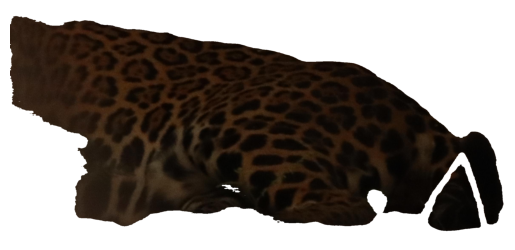

In [8]:
show_image(os.path.join(train_image_path, 'train_0085.png'))

In [9]:
def analyze_image_lighting(image_path):
    img = Image.open(image_path).convert('L')
    gray = np.array(img)

    brightness = np.mean(gray)
    contrast = gray.std()

    hist, _ = np.histogram(gray, bins=256, range=(0, 256))
    dark_pixels = np.sum(hist[:50]) / np.sum(hist) * 100

    return {
        'brightness': brightness,
        'contrast': contrast,
        'dark_percentage': dark_pixels,
        'is_dark': brightness < 40 or dark_pixels > 60,
        'low_contrast': contrast < 20
    }

image_analysis = analyze_image_lighting(os.path.join(train_image_path, 'train_0085.png'))
print(image_analysis)

{'brightness': np.float64(26.051425122978642), 'contrast': np.float64(12.186233117582264), 'dark_percentage': np.float64(97.60625394544076), 'is_dark': np.True_, 'low_contrast': np.True_}


In [10]:
if not os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results = []
    for idx, row in tqdm.tqdm(label_table.iterrows(), total=label_table.shape[0]):
        image_id = row['filename']
        image_path = os.path.join(train_image_path, image_id)
        result = analyze_image_lighting(image_path)
        lighting_contrast_results.append((image_id, result))

100%|██████████| 1895/1895 [07:47<00:00,  4.06it/s]


In [33]:
if not os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results_df = pd.DataFrame(lighting_contrast_results, columns=['filename', 'analysis'])
    lighting_contrast_results_df = pd.json_normalize(lighting_contrast_results_df['analysis'])
    #lighting_contrast_results_df = pd.concat([lighting_contrast_results_df.drop('analysis', axis=1),  lighting_contrast_results_df], axis=1)
    lighting_contrast_results_df.to_csv('intermediate/lighting_contrast_results.csv', index=False)
    print(lighting_contrast_results_df.head())

if os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results_df = pd.read_csv('intermediate/lighting_contrast_results.csv')
    #lighting_contrast_results_df = pd.json_normalize(lighting_contrast_results_df['analysis'])
    #lighting_contrast_results_df = pd.concat([lighting_contrast_results_df.drop('analysis', axis=1),  lighting_contrast_results_df], axis=1)
    print(lighting_contrast_results_df.head())

   brightness   contrast  dark_percentage  is_dark  low_contrast
0   85.682996  40.793495        20.616807    False         False
1   85.288834  40.653441        21.166222    False         False
2   86.395097  40.802523        21.134740    False         False
3   99.181228  23.909947         3.622408    False         False
4  117.765126  39.554654         7.992894    False         False
   brightness   contrast  dark_percentage  is_dark  low_contrast
0   85.682996  40.793495        20.616807    False         False
1   85.288834  40.653441        21.166222    False         False
2   86.395097  40.802523        21.134740    False         False
3   99.181228  23.909947         3.622408    False         False
4  117.765126  39.554654         7.992894    False         False


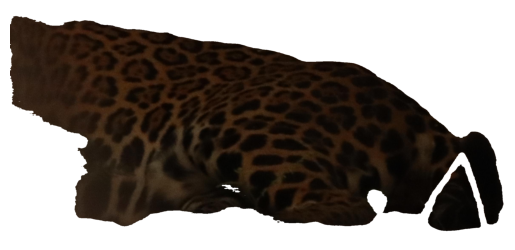

In [34]:
show_image(os.path.join(train_image_path, 'train_0085.png'))